# Generating IC's

In [19]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os
import analysis as an

# force reload
import importlib
importlib.reload(an)


<module 'analysis' from '/home/andrinr/projects/msc-thesis/src/analysis/__init__.py'>

## Matching an Arbitrary Power Spectrum

We start by generating some white noise $n(\mathbf{x})$. Hence we sample it from a random normal distribution.

In [93]:
size = 30 # Mpc/h
n_grid = 128
n_grid_half = n_grid // 2
key, noise_key = jax.random.split(jax.random.PRNGKey(0))
rho = jax.random.normal(noise_key, (n_grid, n_grid, n_grid), dtype=jnp.float32) + 10

We now define a power spectrum, later we will transform the white noise such that it matches the desired power spectrum.

delta mean: 4.9441950977779925e-08, delta std: 0.10000541061162949, delta min: -0.47820568084716797, delta max: 0.5222336649894714
262144.0
262144
Power spectrum: [125.3418   138.51729  123.67795  125.759384 132.64798  124.11774
 129.67758  127.68192  130.0496   128.89374  126.3683   128.13394
 126.96028  127.12696  128.96063  127.57249  128.39508  128.4713
 131.23819  128.60101  128.4386   127.985535 128.64255  128.09496
 127.89463  128.79529  128.85944  127.61431  128.87064  128.26004 ]


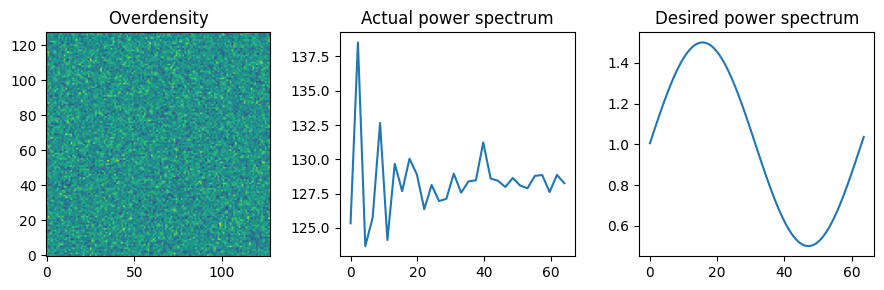

In [94]:
delta = an.compute_overdensity(rho)
print(f"delta mean: {jnp.mean(delta)}, delta std: {jnp.std(delta)}, delta min: {jnp.min(delta)}, delta max: {jnp.max(delta)}")
    


n_bins = 30
power_spectrum = an.PowerSpectrum(N = n_grid, n_bins=n_bins)

k, Pk = power_spectrum(delta)

print(f"Power spectrum: {Pk}")

# lets define a desired power spectrum
k_desired = jnp.linspace(0.1, n_grid, n_grid)
Pk_desired = (jnp.sin(k_desired * 0.1)*0.5 + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Overdensity')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired[:n_grid_half], Pk_desired[:n_grid_half])
ax3.set_title('Desired power spectrum')

plt.tight_layout()


According to Pen et al. (1997), we need to compute the correlation Kernel

$$ 
A(k) = \sqrt{P(k)}.
$$

Then we can convolve the white noise with the correlation Kernel in furier space to generate the density field with the desired power spectrum.

$$
\delta(\mathbf{k}) = n(\mathbf{k}) A(\mathbf{k}).
$$

source : [INITIAL CONDITIONS FOR LARGE COSMOLOGICAL SIMULATIONS](https://arxiv.org/pdf/0804.3536)


There is one confusing aspect to this, as we are looking for 3D correlation Kernel, however our power spectrum is a scalar dimensional function of distance. However we simply generate a correlation kernel, where the the real valued variable k is defined as $k = \sqrt{\mathbf{k}_x^2 + \mathbf{k}_y^2 + \mathbf{k}_z^2}$. Hence a more accurate defintion would be:

$$
A(\mathbf{k}) = \sqrt{P(\langle \mathbf{k} \rangle)}
$$

In [73]:
# lets compute the correlation Kernel
Ax_lin = jnp.sqrt(Pk_desired)

# first we compute an index grid indicating the coordinates in the linear power spectrum array
# from where we need to read the values for each entry in the correlation kernel
coords = jnp.linspace(-n_grid_half, n_grid_half, n_grid, endpoint=False)
x, y, z = jnp.meshgrid(coords, coords, coords, indexing='ij')
index_grid = jnp.sqrt(x**2 + y**2 + z**2)
index_grid = jnp.abs(index_grid)
index_grid = index_grid.astype(jnp.int32)

# assign the values
Ax = Ax_lin.at[index_grid].get()

# transform to fourier space
delta_k = jnp.fft.fftn(delta)
# shift
delta_k = jnp.fft.fftshift(delta_k)
# apply correlation kernel
delta_k_corr = delta_k * Ax
# shift back
delta_k_corr = jnp.fft.ifftshift(delta_k_corr)
# transform back to real space
delta_corr = jnp.fft.ifftn(delta_k_corr).real

Now that we have computed all the values, let us examine the noise, before and after the correlation kernel was applied, and the correlation kernel in furier space.

Text(0.5, 1.0, 'Correlation Kernel')

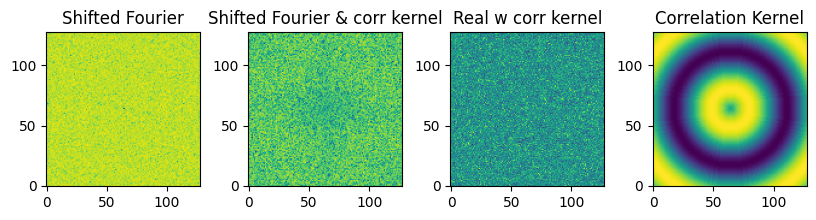

In [74]:

# plot delta_k
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 2))

ax1.imshow(jnp.log10(jnp.abs(delta_k[n_grid//2])), origin='lower')
ax1.set_title('Shifted Fourier')

ax2.imshow(jnp.log10(jnp.abs(delta_k_corr[n_grid//2])), origin='lower')
ax2.set_title('Shifted Fourier & corr kernel')

ax3.imshow(delta_corr[n_grid//2], origin='lower')
ax3.set_title('Real w corr kernel')

ax4.imshow(Ax[n_grid//2], origin='lower')
ax4.set_title('Correlation Kernel')

262144.0
262144


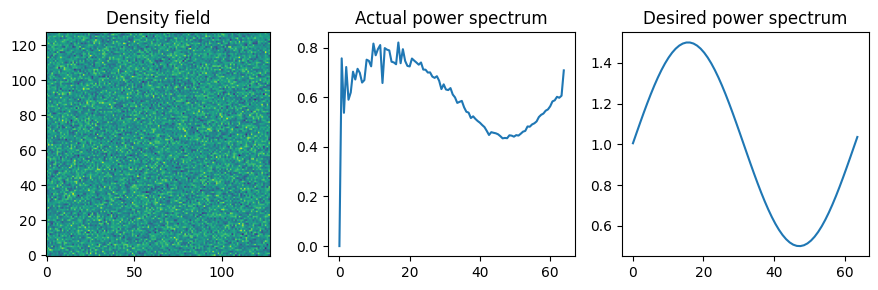

In [75]:
k, Pk = power_spectrum(delta_corr)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta_corr[n_grid_half], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired[:n_grid_half], Pk_desired[:n_grid_half])
ax3.set_title('Desired power spectrum')

plt.tight_layout()

## Real World Power Spectra

In the real world, the mass power spectrum naturally is not a sinus wave. Generally it is assumed that the power spectrum changes with expansion of the universe. We can estimate the power spectrum based on the observations of the cosmic microwave background radiation. However, this only works well in th linear regime and not so much in the non linear regime.

We now leverage the pyccl library to get an estimate of the linear power spectrum (Meaning we exclude non linear effects).


In [12]:
import pyccl as ccl

# Define the cosmological parameters
h               = 0.67
dOmega0         = 0.32
dLambda         = 0.68
dSigma8         = 0.83
dSpectral       = 0.96

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                      transfer_function='boltzmann_class')

kmin, kmax, nk = 1e-4, 1e1, 128
k = jnp.logspace(jnp.log10(kmin), jnp.log10(kmax), nk) # Wavenumber
a = 1. # Scale factor a z=

P_k = ccl.nonlin_matter_power(cosmo, k, a)




CosmoComputationError: 

Error in Class: thermodynamics_init(L:342) :error in thermodynamics_helium_from_bbn(ppr,pba,pth);
=>thermodynamics_helium_from_bbn(L:589) :could not open fA with name /home/andrinr/.local/lib/python3.10/site-packages/class_public/external/bbn/sBBN_2017.dat and mode "r"